PNS-2019 (National Health Survey 2019) – prediction of heart disease by LGBM modeling

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install feature-engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 276 kB 5.2 MB/s 


In [ ]:
!pip install feature-engine catboost lightgbm xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 108 kB/s 


In [ ]:
!pip install shap==0.39.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 356 kB 5.0 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491674 sha256=15ff240dafcbf757dac2a04e707e1e6e7fe00bd2f66f0b84333f23e9ba772053
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import shap
import scikitplot as skplt
from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

from yellowbrick.features import PCA

from feature_engine.imputation import ArbitraryNumberImputer, MeanMedianImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import plotly.express as px


from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import export_graphviz 
from IPython.display import Image

from sklearn import metrics
from sklearn.metrics import plot_roc_curve
from scipy.stats import ks_2samp
from sklearn.metrics import make_scorer, roc_auc_score, log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve

In [ ]:
df_pns_model= pd.read_csv('/content/drive/MyDrive/tcc_files/MBA_TCC_project/Project/GitHub/df_pns_rawdata.csv', sep=',', encoding = "ISO-8859-1")
df_pns_model.drop(df_pns_model.filter(regex="Unname"),axis=1, inplace=True)
df_pns_model

,index,Workforce,State,Live,Education,Income,Gender,Age,SkinColor,OralHealth,...,OCD,COPD,Cancer,KidneyFailure,SaltConsump,Alcohol,onTV,onPhoneComput,Smoke,Smoked
0,0,Able,RO,Capital,<9y,1/4-1/2mw,Female,55.0,whrite,<1y,...,0.0,0.0,0.0,0.0,Fair,<1month,2_3h_day,<1h_day,NoSmook,YesDaily
1,9,Able,RO,Capital,<12y,1/4-1/2mw,Female,19.0,brown,<1y,...,0.0,0.0,0.0,0.0,Fair,<1month,DontSeeTV,>6h_day,YesDaily,YesDaily
2,10,Able,RO,Capital,12y,1/2-1mw,Female,45.0,black,>3y,...,0.0,0.0,0.0,0.0,Low,>=1month,1_2h_day,1_2h_day,NoSmook,YesDaily
3,18,Able,RO,Capital,<1y,1/4-1/2mw,Female,58.0,black,<1y,...,0.0,0.0,0.0,0.0,Fair,NoDrink,<1h_day,3_6h_day,NoSmook,NoSmook
4,19,Unable,RO,Capital,<16,<1/4mw,Female,28.0,brown,<1y,...,0.0,0.0,0.0,0.0,Fair,NoDrink,1_2h_day,<1h_day,NoSmook,NoSmook
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81213,285161,Able,GO,Other,<9y,1/2-1mw,Male,22.0,whrite,>3y,...,0.0,0.0,0.0,0.0,Fair,>=1month,1_2h_day,<1h_day,NoSmook,YesNotDaily
81214,285166,Able,GO,Other,<9y,1/4-1/2mw,Female,39.0,brown,1-2y,...,0.0,0.0,0.0,0.0,Much,NoDrink,1_2h_day,<1h_day,NoSmook,NoSmook
81215,285169,Unable,GO,Other,<9y,1/2-1mw,Female,71.0,brown,>3y,...,0.0,0.0,1.0,0.0,Low,NoDrink,3_6h_day,DontUseComp,NoSmook,NoSmook
81216,285172,Unable,GO,Other,<9y,1/4-1/2mw,Female,46.0,brown,>3y,...,0.0,0.0,0.0,0.0,Low,NoDrink,<1h_day,2_3h_day,NoSmook,NoSmook


In [ ]:
df=df_pns_model['HeartDisease'].value_counts(normalize=True)
df = df.mul(100).round(2)
fig = px.bar(df, x='HeartDisease', width=800, height=400, color_discrete_sequence=["navy"], template="simple_white",
             title='Frequency of Heart Disease', labels={'index':'0=NoDiagnosis; 1=Diagnosis', 'HeartDisease':'% frequency'},text_auto=True)
fig.update_layout(showlegend=False, xaxis_ticksuffix = "%")
fig.update_yaxes(nticks=3)
fig.show()

In [ ]:
# Numerical Variables
num_vars = ['Age','VegesGreens', 'RedMeat', 'WhiteMeat', 'Fish', 'Juice', 'FruitJuice', 'Fruit', 'SodaDrink', 'Milk','Cookie', 'JunkFood', 'HeartDiseaseAge', 'StrokeAge', 
            'DiabetesAge', 'DyslipidemiaAge', 'PhysSport', 'BloodPresure', 'Diabetes', 'Dyslipidemia', 'PrivateHCare', 'StayedHospital', 'Stroke', 'AsthmaBronchitis', 'ArthritisRheumatism',
            'Backache', 'RepetStrainInjury', 'OCD','BMI', 'COPD', 'Cancer', 'KidneyFailure', 'Depresssion']

# Categorical Variables
cat_vars = ['SaltConsump', 'Alcohol', 'onTV', 'onPhoneComput', 'Smoke', 'Smoked', 'OralHealth', 'Education', 'Income', 'Gender', 'Live']

# Target Variable
target = 'HeartDisease'

# list of features
features = cat_vars + num_vars

# filtering features from the raw data dataset
X = df_pns_model[features]

# filtering target features
y = df_pns_model[target]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=30)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((64974, 44), (16244, 44), (64974,), (16244,))

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train[num_vars])

X_train_num_scaled = pd.DataFrame(scaler.transform(X_train[num_vars]), columns=num_vars)
X_test_num_scaled = pd.DataFrame(scaler.transform(X_test[num_vars]), columns=num_vars)

In [ ]:
ohe = OneHotEncoder(variables=cat_vars)
X_train_cat_ohe = ohe.fit_transform(X_train[cat_vars])
X_test_cat_ohe  = ohe.transform(X_test[cat_vars])

In [ ]:
X_train_num_scaled = X_train_num_scaled.set_index(X_train.index)
X_test_num_scaled  = X_test_num_scaled.set_index(X_test.index)

X_train_cat_ohe = X_train_cat_ohe.set_index(X_train.index)
X_test_cat_ohe = X_test_cat_ohe.set_index(X_test.index)

In [ ]:
X_train_transformed = pd.concat([X_train_num_scaled, X_train_cat_ohe ], axis='columns')
X_train_transformed

,Age,VegesGreens,RedMeat,WhiteMeat,Fish,Juice,FruitJuice,Fruit,SodaDrink,Milk,...,Income_>5mw,Income_<1/4mw,Income_2-3mw,Income_3-5mw,Gender_Female,Gender_Male,Live_Capital,Live_MetroArea,Live_Other,Live_OtherCity
8021,-1.224839,-0.541205,-0.623837,0.628194,-0.748234,-0.563582,-0.258583,-0.392121,-0.072234,0.797951,...,0,0,0,0,1,0,1,0,0,0
46721,-0.484873,1.074353,1.786183,2.328186,3.839517,0.894613,1.815227,1.210146,-0.639337,-1.186613,...,0,0,0,0,1,0,0,1,0,0
78233,-1.794043,-0.945094,-0.141833,-0.505135,0.562552,1.380678,-1.088107,-0.392121,1.061972,-1.186613,...,0,0,0,0,0,1,0,0,1,0
76963,0.938138,1.074353,-0.623837,0.061529,-0.748234,-0.563582,0.570941,1.210146,-0.072234,1.128712,...,0,0,0,0,1,0,1,0,0,0
79284,0.995058,-1.348984,1.786183,2.328186,-0.748234,-0.563582,-1.088107,-0.792687,-0.639337,1.128712,...,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66455,-0.997157,0.266574,0.822175,1.194858,1.217945,-0.077517,-0.258583,-0.792687,0.494869,-1.186613,...,0,0,1,0,0,1,1,0,0,0
46220,-1.395600,-0.137315,1.786183,2.328186,-0.748234,-0.563582,-0.673345,-1.593821,-0.639337,1.128712,...,0,0,0,0,0,1,0,1,0,0
48045,-0.712555,-0.137315,1.786183,-1.638463,-0.748234,-0.563582,1.815227,-0.792687,0.494869,-1.186613,...,0,0,0,0,0,1,0,0,1,0
70053,-0.940237,0.266574,1.786183,-1.071799,-0.748234,-0.563582,-0.673345,1.210146,-0.072234,-0.194331,...,0,0,0,0,1,0,1,0,0,0


In [ ]:
X_test_transformed = pd.concat([X_test_num_scaled, X_test_cat_ohe], axis='columns')
X_test_transformed

,Age,VegesGreens,RedMeat,WhiteMeat,Fish,Juice,FruitJuice,Fruit,SodaDrink,Milk,...,Income_>5mw,Income_<1/4mw,Income_2-3mw,Income_3-5mw,Gender_Female,Gender_Male,Live_Capital,Live_MetroArea,Live_Other,Live_OtherCity
11251,-1.167918,-1.348984,-0.141833,0.061529,0.562552,-0.563582,1.815227,-0.792687,-0.639337,1.128712,...,0,0,0,0,1,0,0,1,0,0
61700,0.084331,-1.348984,-1.587845,2.328186,1.217945,0.894613,0.985703,-1.593821,-0.639337,-1.186613,...,0,1,0,0,1,0,0,0,1,0
69623,0.824297,0.266574,-0.141833,0.061529,-0.748234,-0.563582,-1.088107,0.809580,-0.072234,-1.186613,...,0,0,0,0,1,0,0,0,1,0
14891,0.368933,-0.137315,-0.623837,1.194858,1.873338,-0.077517,1.815227,1.210146,-0.072234,0.797951,...,0,0,0,0,1,0,0,1,0,0
37252,-1.167918,-1.752873,-1.105841,-0.505135,-0.748234,0.408548,-0.673345,-0.792687,-0.639337,-0.525092,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37219,-1.281759,-1.752873,-0.623837,0.061529,-0.748234,-0.563582,-1.088107,-1.593821,-0.639337,-1.186613,...,0,0,0,0,0,1,0,1,0,0
69332,1.051979,1.074353,-1.105841,2.328186,-0.092841,-0.563582,1.815227,1.210146,-0.639337,-1.186613,...,0,0,1,0,1,0,0,0,1,0
48875,-0.997157,1.074353,0.340171,-0.505135,-0.092841,-0.563582,-1.088107,1.210146,-0.639337,1.128712,...,0,0,0,0,1,0,1,0,0,0
40527,-0.143351,0.670464,-1.587845,-0.505135,-0.092841,-0.563582,1.815227,1.210146,-0.072234,1.128712,...,0,0,0,0,1,0,1,0,0,0


Training: LGBM modeling

In [ ]:
lgbm = Pipeline(steps=[
    ('LGBMClassifier', LGBMClassifier(random_state=42, class_weight={0:1,1:16}))
])

skf=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

cv_results = cross_val_score(estimator=lgbm, X=X_train_transformed, y=y_train, scoring='recall', cv=skf, n_jobs=-1)
print(cv_results.mean()), print(cv_results.std())

0.6163101604278075


In [ ]:
lgbm.fit(X_train_transformed, y_train)

Pipeline(steps=[('LGBMClassifier',
                 LGBMClassifier(class_weight={0: 1, 1: 16}, random_state=42))])

In [ ]:
y_pred_train = lgbm.predict(X_train_transformed)
y_proba_train = lgbm.predict_proba(X_train_transformed)[:, 1]
print(f'RoC-AUC LGBM_train: {roc_auc_score(y_train, y_proba_train)}')
print(f'Recall LGBM_train: {recall_score(y_train, y_pred_train)}')
print(f'Precision LGBM_train: {precision_score(y_train, y_pred_train)}')

RoC-AUC LGBM_train: 0.8738459344787481
Recall LGBM_train: 0.7986631016042781
Precision LGBM_train: 0.1843144514377391


In [ ]:
y_pred_test = lgbm.predict(X_test_transformed)
y_proba_test = lgbm.predict_proba(X_test_transformed)[:, 1]

print(f'RoC-AUC LGBM_test: {roc_auc_score(y_test, y_proba_test)}')
print(f'Recall LGBM_test: {recall_score(y_test, y_pred_test)}')
print(f'Precision LGBM_test: {precision_score(y_test, y_pred_test)}')

RoC-AUC LGBM_test: 0.7754125794445129
Recall LGBM_test: 0.637400228050171
Precision LGBM_test: 0.14303991811668373


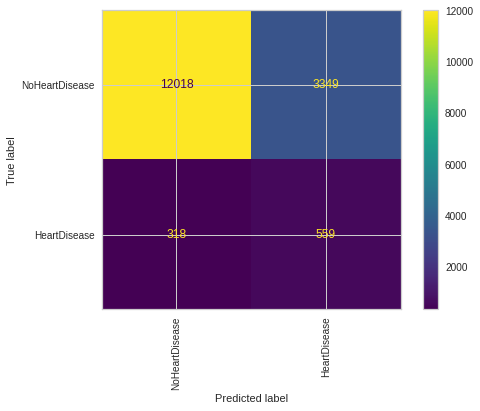

In [ ]:
plot_confusion_matrix(lgbm, X_test_transformed, y_test, values_format='d', display_labels=['NoHeartDisease', 'HeartDisease'], xticks_rotation='vertical')

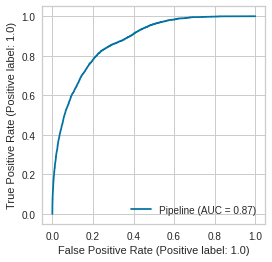

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
plot_roc_curve(lgbm, X_train_transformed, y_train, ax=ax)
plt.show()

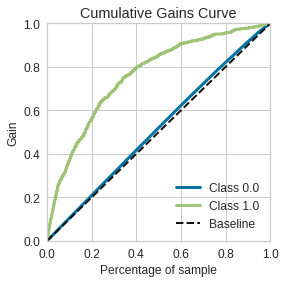

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
y_probas=lgbm.predict_proba(X_test_transformed)
skplt.metrics.plot_cumulative_gain(y_test, y_probas, ax=ax)
plt.show()

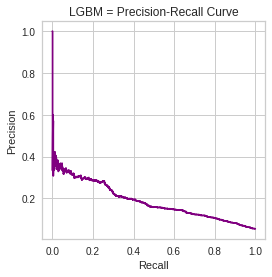

In [ ]:
y_score = lgbm.predict_proba(X_test_transformed)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

fig, ax = plt.subplots(figsize=(4,4))
ax.plot(recall, precision, color='purple')

ax.set_title('LGBM = Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

plt.show()

Parameters Optimization GridSearch - LGBM

In [ ]:
LGBM_GS = Pipeline(steps=[('lgbm', LGBMClassifier())])

parametros = {
    'lgbm__learning_rate': [0.01, 0.02, 0.025], 
    'lgbm__n_estimators': [100, 300, 500],
    'lgbm__max_depth': [7, 9, 11] }

grid_search = GridSearchCV(estimator=LGBM_GS, param_grid=parametros, scoring='recall', cv=skf, n_jobs=-1, verbose=2)

grid_search.fit(X_train_transformed, y_train)

print()
print('='*100)
print(grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits

{'lgbm__learning_rate': 0.025, 'lgbm__max_depth': 7, 'lgbm__n_estimators': 500}


In [ ]:
lgbm_GS = Pipeline(steps=[
    ('LGBMClassifier', LGBMClassifier(random_state=42, class_weight={0:1,1:16}, learning_rate=0.02, max_depth=9, n_estimators=200))
])

skf=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

cv_results = cross_val_score(estimator=lgbm_GS, X=X_train_transformed, y=y_train, scoring='recall', cv=skf, n_jobs=-1)
print(cv_results.mean())

0.6815508021390374


In [ ]:
lgbm_GS.fit(X_train_transformed, y_train)

Pipeline(steps=[('LGBMClassifier',
                 LGBMClassifier(class_weight={0: 1, 1: 16}, learning_rate=0.02,
                                max_depth=9, n_estimators=200,
                                random_state=42))])

In [ ]:
y_pred_train = lgbm_GS.predict(X_train_transformed)
y_proba_train = lgbm_GS.predict_proba(X_train_transformed)[:, 1]
print(f'RoC-AUC LGBM/GS_train: {roc_auc_score(y_train, y_proba_train)}')
print(f'Recall LGBM/GS_train: {recall_score(y_train, y_pred_train)}')
print(f'Precision LGBM/GS_train: {precision_score(y_train, y_pred_train)}')

RoC-AUC LGBM/GS_train: 0.8297822336302977
Recall LGBM/GS_train: 0.7641711229946524
Precision LGBM/GS_train: 0.1550732501356484


In [ ]:
y_pred_test = lgbm_GS.predict(X_test_transformed)
y_proba_test = lgbm_GS.predict_proba(X_test_transformed)[:, 1]

print(f'RoC-AUC LGBM/GS_test: {roc_auc_score(y_test, y_proba_test)}')
print(f'Recall LGBM/GS_test: {recall_score(y_test, y_pred_test)}')
print(f'Precision LGBM/GS_test: {precision_score(y_test, y_pred_test)}')

RoC-AUC LGBM/GS_test: 0.784629044497683
Recall LGBM/GS_test: 0.6978335233751425
Precision LGBM/GS_test: 0.13615127919911013


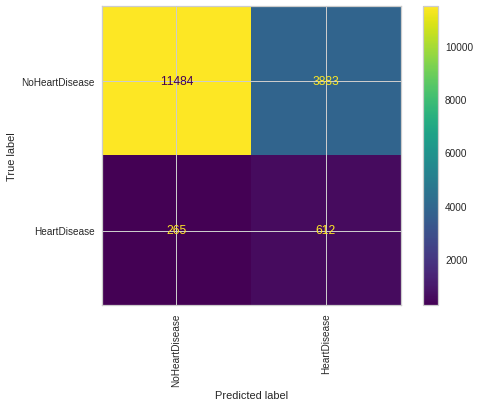

In [ ]:
plot_confusion_matrix(lgbm_GS, X_test_transformed, y_test, values_format='d', display_labels=['NoHeartDisease', 'HeartDisease'], xticks_rotation='vertical')

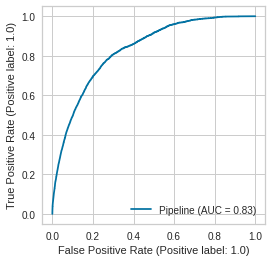

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
plot_roc_curve(lgbm_GS, X_train_transformed, y_train, ax=ax)
plt.show()

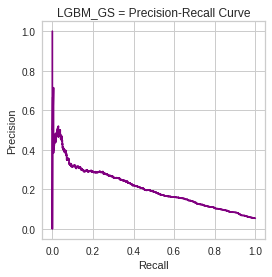

In [ ]:
y_score = lgbm_GS.predict_proba(X_test_transformed)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

fig, ax = plt.subplots(figsize=(4,4))
ax.plot(recall, precision, color='purple')

ax.set_title('LGBM_GS = Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

plt.show()

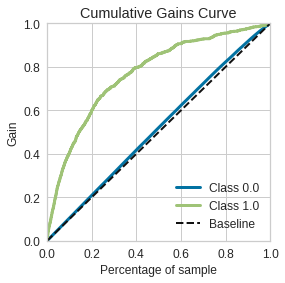

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
y_probas=lgbm_GS.predict_proba(X_test_transformed)
skplt.metrics.plot_cumulative_gain(y_test, y_probas, ax=ax)
plt.show()

In [ ]:
X_test['cardio_pred'] = lgbm_GS.predict(X_test_transformed)
X_test['cardio_proba'] = lgbm_GS.predict_proba(X_test_transformed)[:, 1]
X_test.head()

,SaltConsump,Alcohol,onTV,onPhoneComput,Smoke,Smoked,OralHealth,Education,Income,Gender,...,Backache,RepetStrainInjury,OCD,BMI,COPD,Cancer,KidneyFailure,Depresssion,cardio_pred,cardio_proba
11251,Low,NoDrink,<1h_day,2_3h_day,NoSmook,NoSmook,<1y,12y,1-2mw,Female,...,1.0,0.0,0.0,15.57,0.0,0.0,0.0,0.0,0.0,0.397635
61700,VeryLow,>=1month,1_2h_day,<1h_day,NoSmook,YesDaily,<1y,<9y,<1/4mw,Female,...,0.0,0.0,0.0,24.22,0.0,0.0,0.0,0.0,0.0,0.313865
69623,VeryLow,>=1month,1_2h_day,DontUseComp,YesDaily,YesDaily,<1y,12y,1-2mw,Female,...,1.0,0.0,0.0,30.33,0.0,0.0,0.0,1.0,1.0,0.861193
14891,Fair,NoDrink,1_2h_day,3_6h_day,NoSmook,NoSmook,1-2y,>18y,1-2mw,Female,...,0.0,0.0,0.0,23.03,0.0,0.0,0.0,0.0,0.0,0.161014
37252,Fair,<1month,DontSeeTV,DontUseComp,NoSmook,YesDaily,>3y,9y,1/2-1mw,Male,...,0.0,0.0,0.0,27.76,0.0,0.0,0.0,0.0,0.0,0.164266


In [ ]:
df_lgbm_prop=(
    X_test
    .filter(['cardio_pred', 'cardio_proba']))
df_lgbm_prop = pd.concat([df_lgbm_prop, y_test], axis='columns')   

In [ ]:
def classe_prob (Q):
  if Q <= 0.10: 
    return "<10%" 
  elif Q >=0.1 and Q <0.20: 
    return "10-20%" 
  elif Q >=0.20 and Q <0.30: 
    return "20-30%" 
  elif Q >=0.30 and Q <0.40: 
    return "30-40%" 
  elif Q >=0.40 and Q<=0.50: 
    return "40-50%" 
  elif Q >=0.50 and Q<=0.60: 
    return "50-60%" 
  elif Q >=0.60 and Q <0.70: 
    return "60-70%" 
  elif Q >=0.70 and Q <0.80: 
    return "70-80%" 
  elif Q >=0.80 and Q <0.90: 
    return "80-90%" 
  elif Q >=0.90 and Q<=1: 
    return "90-100%"

df_lgbm_prop["cardio_proba_range"] = df_lgbm_prop['cardio_proba'].apply(classe_prob) 
df_lgbm_prop['cardio_proba'].sort_values(ascending=False) 
df_lgbm_prop.reset_index() 
df_lgbm_prop.head(5)

,cardio_pred,cardio_proba,HeartDisease,cardio_proba_range
11251,0.0,0.397635,0.0,30-40%
61700,0.0,0.313865,1.0,30-40%
69623,1.0,0.861193,0.0,80-90%
14891,0.0,0.161014,0.0,10-20%
37252,0.0,0.164266,0.0,10-20%


In [ ]:
df = df_lgbm_prop.groupby(['cardio_proba_range', 'cardio_pred']).agg(count=("cardio_pred", 'count'))
df = df.reset_index()
df

,cardio_proba_range,cardio_pred,count
0,10-20%,0.0,3673
1,20-30%,0.0,4718
2,30-40%,0.0,1403
3,40-50%,0.0,1950
4,50-60%,1.0,1610
5,60-70%,1.0,1242
6,70-80%,1.0,1063
7,80-90%,1.0,573
8,90-100%,1.0,7
9,<10%,0.0,5


In [ ]:
df = df_lgbm_prop.groupby(['cardio_proba_range', 'HeartDisease', 'cardio_pred']).agg(count=("HeartDisease", 'count'))
df['count%'] = (df['count'] / df['count'].sum()).round(4) * 100
df = df.reset_index()
df

,cardio_proba_range,HeartDisease,cardio_pred,count,count%
0,10-20%,0.0,0.0,3629,22.34
1,10-20%,1.0,0.0,44,0.27
2,20-30%,0.0,0.0,4630,28.50
3,20-30%,1.0,0.0,88,0.54
4,30-40%,0.0,0.0,1357,8.35
5,30-40%,1.0,0.0,46,0.28
6,40-50%,0.0,0.0,1863,11.47
7,40-50%,1.0,0.0,87,0.54
8,50-60%,0.0,1.0,1482,9.12
9,50-60%,1.0,1.0,128,0.79


In [ ]:
df['ON/OFF']=df.apply(lambda x: 'ON' if x['HeartDisease'] == x['cardio_pred'] else 'OFF', axis=1)
df = df.reset_index()
df

,index,cardio_proba_range,HeartDisease,cardio_pred,count,count%,ON/OFF
0,0,10-20%,0.0,0.0,3629,22.34,ON
1,1,10-20%,1.0,0.0,44,0.27,OFF
2,2,20-30%,0.0,0.0,4630,28.50,ON
3,3,20-30%,1.0,0.0,88,0.54,OFF
4,4,30-40%,0.0,0.0,1357,8.35,ON
5,5,30-40%,1.0,0.0,46,0.28,OFF
6,6,40-50%,0.0,0.0,1863,11.47,ON
7,7,40-50%,1.0,0.0,87,0.54,OFF
8,8,50-60%,0.0,1.0,1482,9.12,OFF
9,9,50-60%,1.0,1.0,128,0.79,ON


In [ ]:
fig = px.bar(df, x='cardio_proba_range', y='count%', color='ON/OFF', width=800, height=400, template="simple_white",barmode = 'group',
             title='Probability to Target: Heart Disease', labels={'cardio_proba_range':'Range of Probabilities', 'count%':'ON or OFF target'},text_auto=True, 
             color_discrete_map={'ON': 'red','OFF': 'green'})
fig.update_layout(showlegend=True, xaxis_ticksuffix = "%")
fig.show()

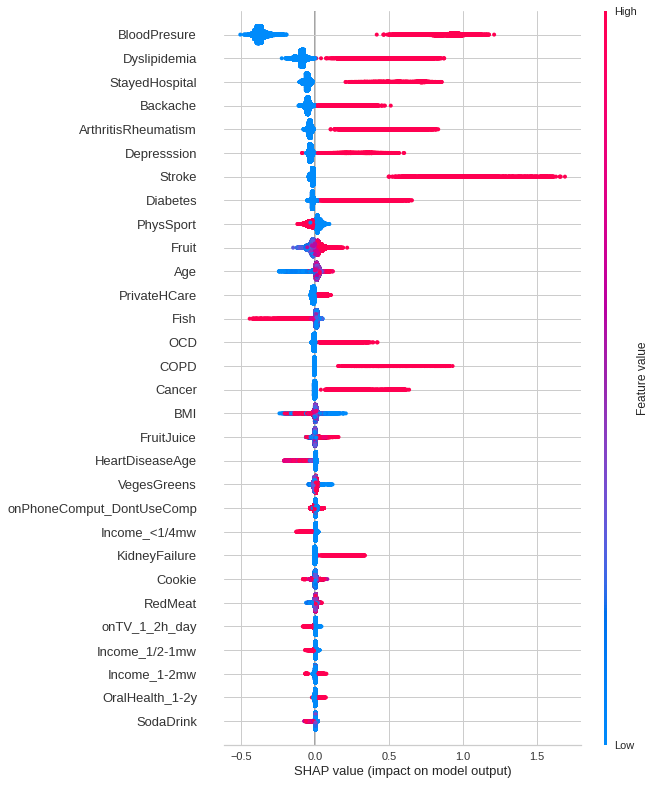

In [ ]:
explainer = shap.TreeExplainer(lgbm_GS[-1])
shap_values = explainer.shap_values(X_train_transformed)

shap.summary_plot(shap_values[1], X_train_transformed, plot_type='dot', max_display=30)

100%|===================| 64854/64974 [04:49<00:00]       

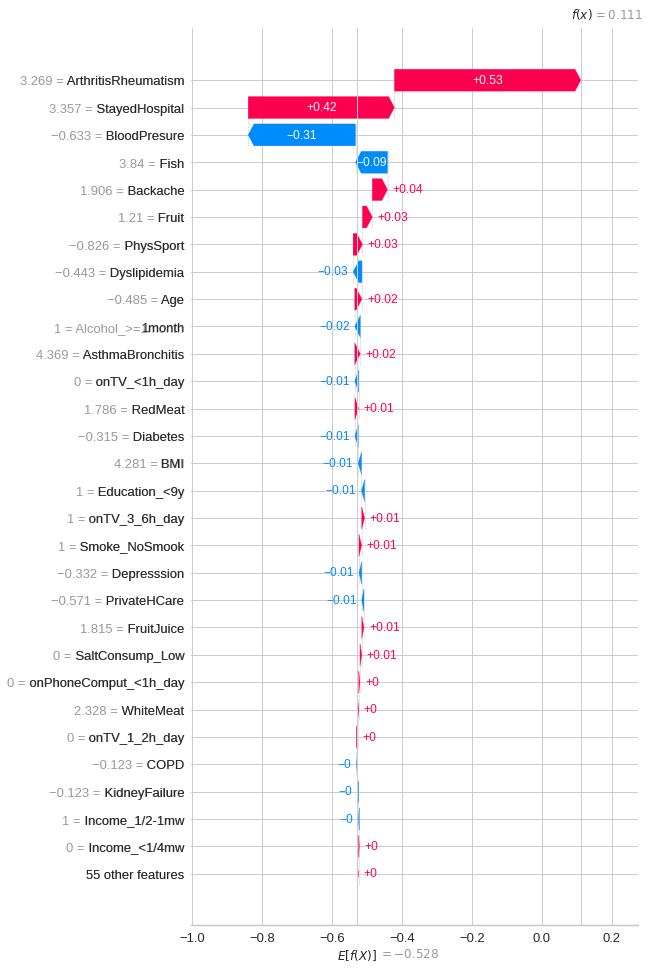

In [ ]:
explainer = shap.TreeExplainer(lgbm_GS[-1], X_train_transformed)
explanation_object = explainer(X_train_transformed)
shap_values = explainer.shap_values(X_train_transformed)
shap.plots.waterfall(explanation_object[1],  max_display=30)

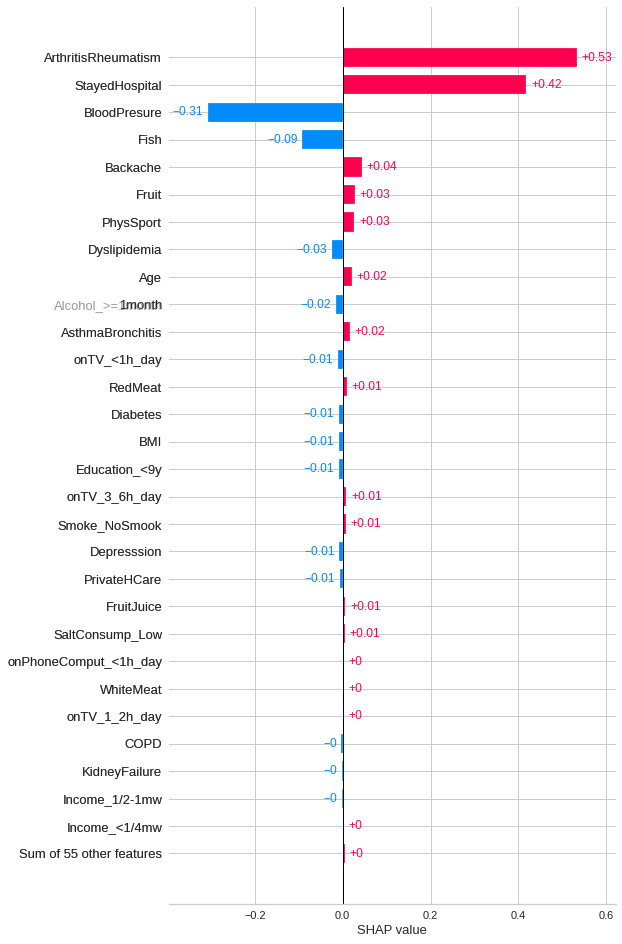

In [ ]:
shap.plots.bar(explanation_object[1], max_display=30)

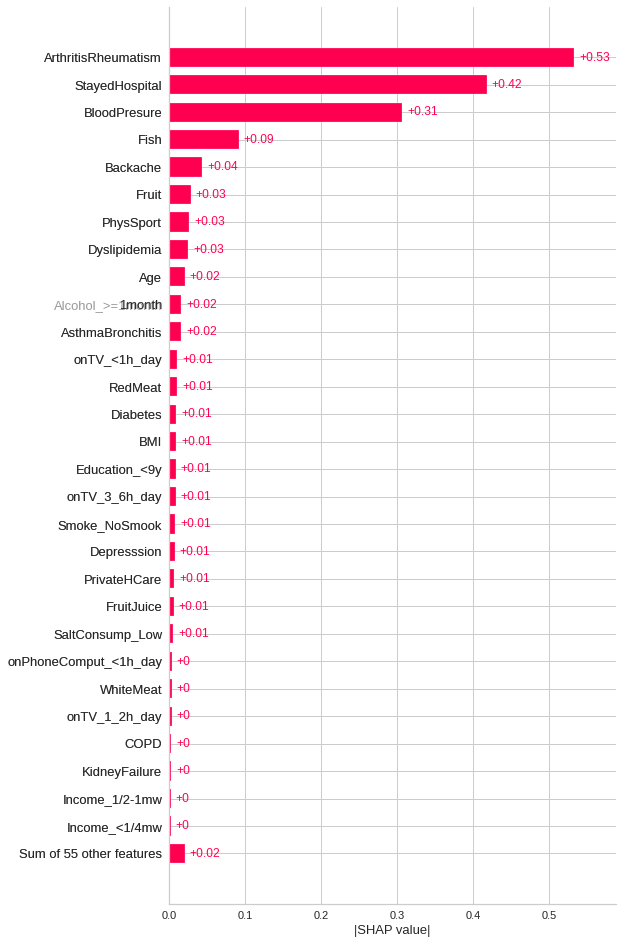

In [ ]:
shap.plots.bar(explanation_object[1].abs, max_display=30)